In [10]:
import pandas as pd
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
plt.style.use('seaborn-whitegrid')

from utils import PkdbModel, ccolors ,markers,category_filter_strict,category_filter_soft,filter_df,\
    abs_idx,rel_idx,group_idx,individual_idx \

plt.rcParams.update({
        'axes.labelsize': '20',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': '20',
        'xtick.labelsize': '20',
        'ytick.labelsize': '20',
        'figure.facecolor': '1.00'
    })


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.read()
caffeine_clearance = caffeine_clr.data
caffeine_clearance.groupby("study")

In [4]:
caffeine_clearance["outlier"] = False
caffeine_clearance.loc[caffeine_clearance["study"]== "Balogh1992","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1988","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1989","outlier"] = True

In [ ]:
ccolors = {'control': 'black',
           'smoking': 'blue',
           'oc': 'green',
           'outlier': 'red',
           'rest':'brown'
          }
markers = {'control': 's',
           'smoking': 'd',
           'oc': 'o',
            'outlier': 'x',
           'rest':'x',

          }

In [75]:

def control_idx(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & ((data[ ('oral contraceptives', 'choice')] == 'N') | ((data[('oral contraceptives', 'choice')].isnull()) & (data[('medication', 'choice')] == "N")))

def smoking_idx(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
           & (data.outlier == False) \

def oc_idx(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') 

def outlier_idx(data):
    return  data.outlier == True

def rest_idx(data):
    return (~outlier_idx(data) & ~smoking_idx(data)  & ~oc_idx(data) & ~control_idx(data))

In [76]:
def control_idx_strict(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'N')
def smoking_idx_strict(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
         & (data[ ('oral contraceptives', 'choice')] == 'N') \
           & (data.outlier == False) 

def oc_idx_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'N') 

def oc_smoking_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'N') 

def rest_idx_strict(data):
        return (~control_idx_strict(data) & ~smoking_idx_strict(data)  & ~oc_idx_strict(data) & ~outlier_idx(data))



In [77]:
PlotCategory =  namedtuple('PlotCategory', ['name','color', 'marker','data_idx'])

In [78]:
categories_soft = [PlotCategory(name="control", color='black', marker='s', data_idx=control_idx),
              PlotCategory(name="smoking", color='blue', marker='d', data_idx=smoking_idx),
              PlotCategory(name="oc", color='green', marker='o', data_idx=oc_idx),
              PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
              PlotCategory(name="rest", color='brown', marker='x', data_idx=rest_idx),
             ]

In [79]:
categories_strict = [PlotCategory(name="control", color='black', marker='s', data_idx=control_idx_strict),
              PlotCategory(name="smoking", color='blue', marker='d', data_idx=smoking_idx_strict),
              PlotCategory(name="oc", color='green', marker='o', data_idx=oc_idx_strict),
              PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
              PlotCategory(name="rest", color='brown', marker='x', data_idx=rest_idx_strict),
             ]

In [80]:
#caffeine_clearance=caffeine_clearance.groupby("study").get_group("Park2003")
# caffeine clearance
def create_plots(df,categories,fig_path):
    fig1, ax1, = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
    fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
    fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
    fig4, ax4 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))

    dinds = [abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
             rel_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
             abs_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit"),
             rel_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit")]

    for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
        df = caffeine_clearance[inds & individual_idx(caffeine_clearance)]
        df_group = caffeine_clearance[inds & group_idx(caffeine_clearance)]

        for plot_category in categories:
            df_category = df[plot_category.data_idx(df)]
            #cf_filter = category_filter[category]
            #df_category = filter_df(cf_filter,df)
            x = df_category["value_intervention"]
            y = df_category["value"]
            ax.scatter(x, y,color=plot_category.color, marker=plot_category.marker, alpha=0.5,label=None,  s=20)
            units = df_category["unit"].unique()
            unit_intervention = df_category["unit_intervention"].unique()

            assert len(units) <= 1, units
            try:
                ax.set_ylabel(f'caffeine clearance [{units[0]}]')
                ax.set_xlabel(f'caffeine dose [{unit_intervention[0]}]')
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

            except IndexError: 
                pass

            df_category = df_group[plot_category.data_idx(df_group)]
            df_category = df_category[df_category["mean"].notnull()]
            x_group = df_category["value_intervention"]
            y_group = df_category["mean"]
            
            if ax in (ax2, ax4):
                xerr_group = (df_category[("weight","sd")]/df_category[("weight","mean")])*x_group
            else:
                xerr_group = 0
            yerr_group = df_category["se"]

            ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=xerr_group, color=plot_category.color, fmt=plot_category.marker,  label=f"{plot_category.name}(Individuals.:{len(x)},Groups:{len(x_group)})",ms=10, alpha=0.7)
            for i, txt in enumerate(df_category[('study', '')]):
                ax.annotate(txt, (x_group.iloc[[i]]+(0.01*x_group.max()),
                                  y_group.iloc[[i]]+(0.01*y_group.max())), alpha=0.7)

    for ax in (ax1, ax2, ax3, ax4):

        ax.set_title('Clearance')
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.legend()
        
    fig1.savefig(os.path.join(fig_path,"clearence_abs-vs-dosing_abs.svg"), bbox_inches="tight")
    fig2.savefig(os.path.join(fig_path,"clearence_rel-vs-dosing_abs.svg"), bbox_inches="tight")
    fig3.savefig(os.path.join(fig_path,"clearence_abs-vs-dosing_rel.svg"), bbox_inches="tight")
    fig4.savefig(os.path.join(fig_path,"clearence_rel-vs-dosing_rel.svg"), bbox_inches="tight")


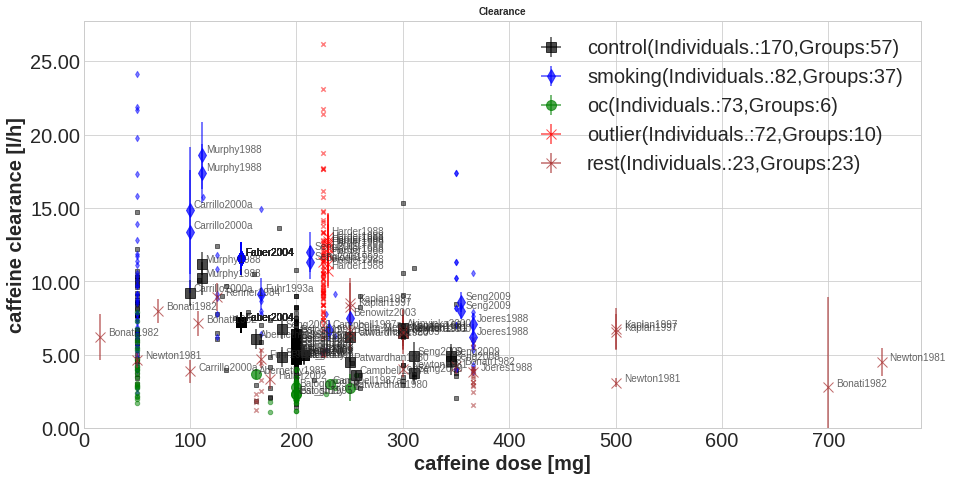

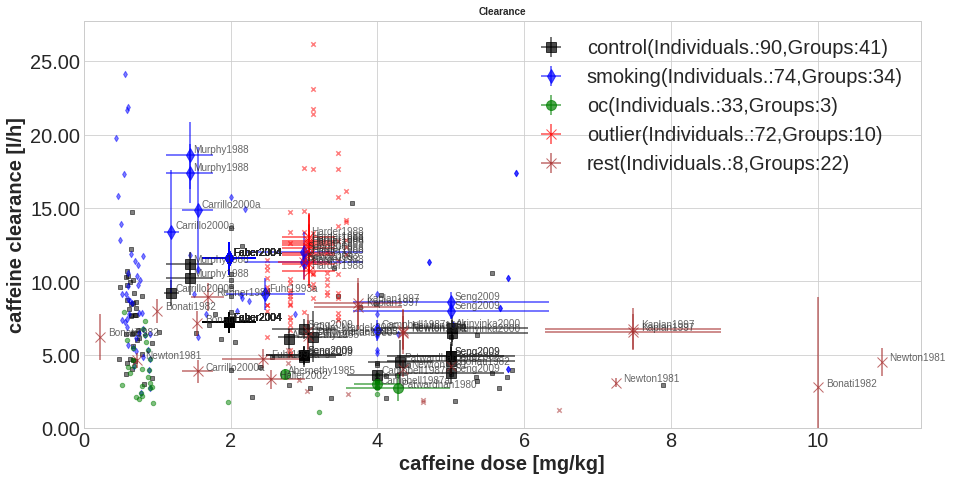

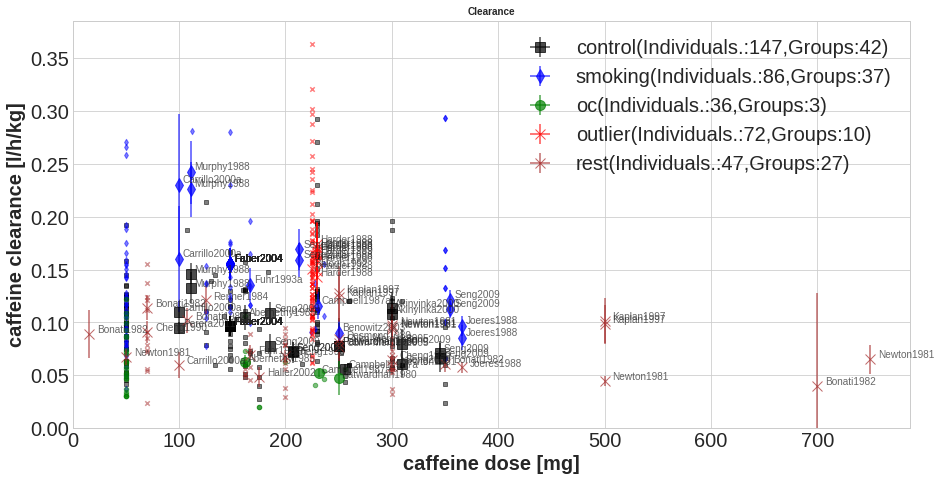

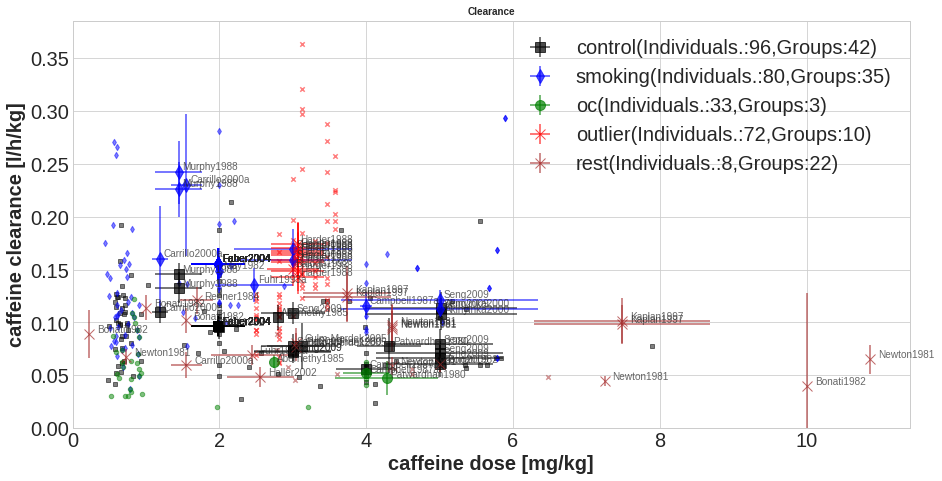

In [81]:
create_plots(caffeine_clearance,categories_soft,"./reports/soft")

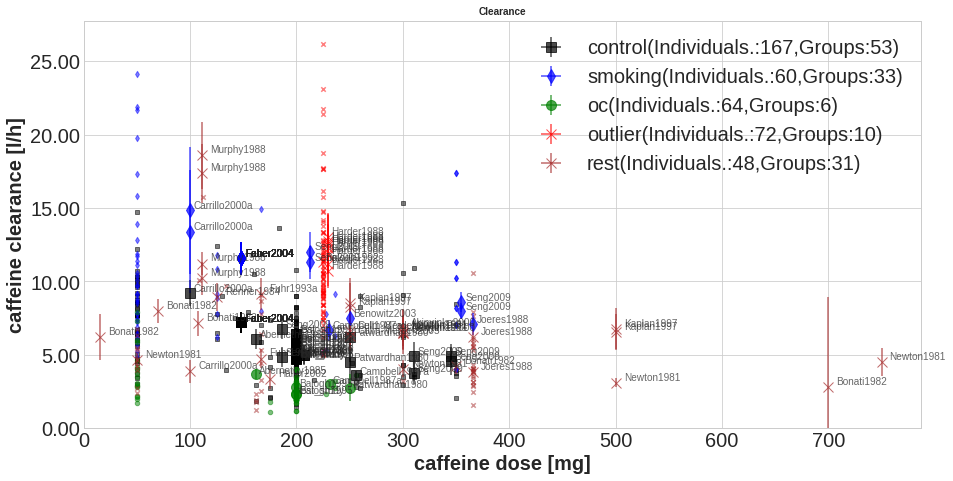

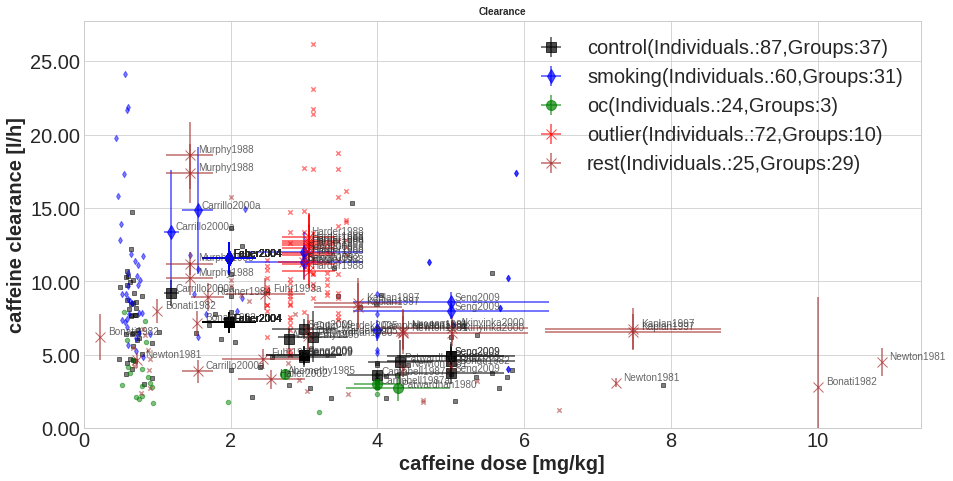

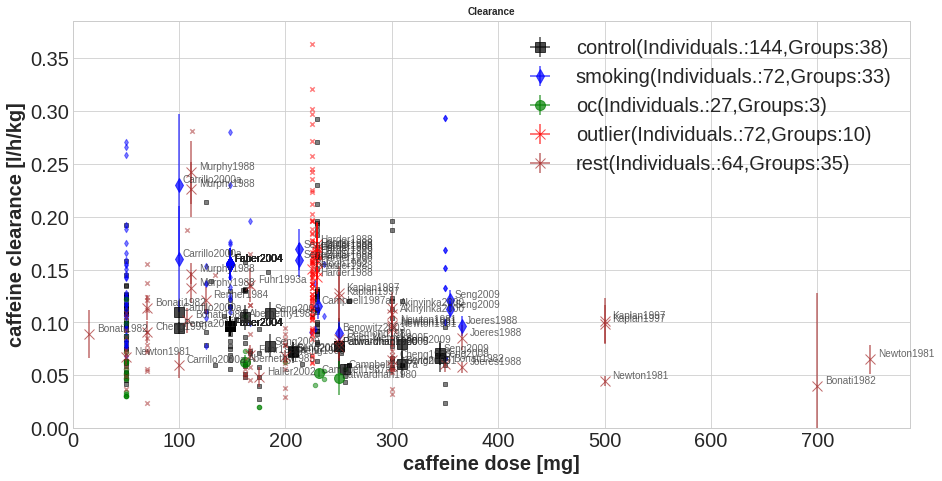

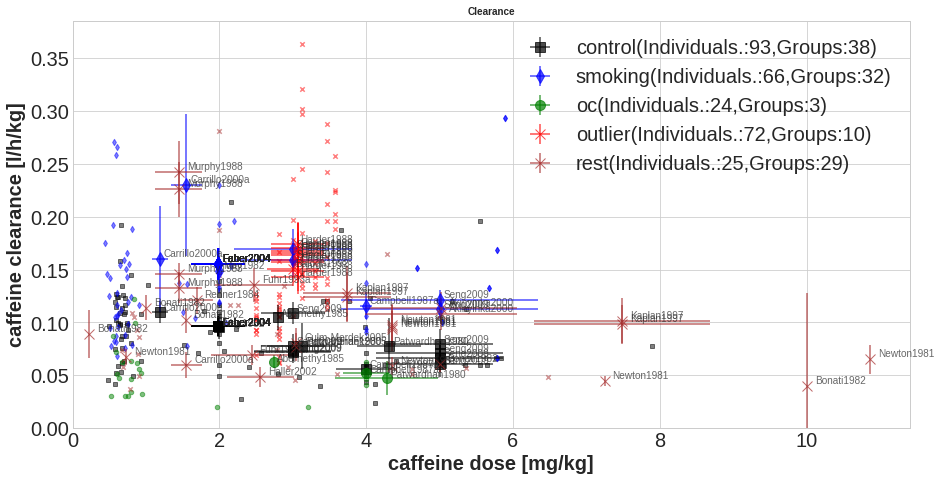

In [82]:
create_plots(caffeine_clearance,categories_strict,"./reports/strict")

In [84]:
caffeine_clearance[abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit")].groupby("subject_type").count()

,study,output_type,pk,tissue,substance_name,pktype,unit,interventions,individual_pk,value,...,"(lean body mass, mean)","(lean body mass, sd)","(lean body mass, se)","(lean body mass, unit)","(metabolic ratio, count)","(metabolic ratio, max)","(metabolic ratio, mean)","(metabolic ratio, min)","(metabolic ratio, unit)",outlier
subject_type,,,,,,,,,,,,,,,,,,,,,
group,134,134,134,134,134,134,134,134,0,0,...,0,0,0,0,0,0,0,0,0,134
individual,411,411,411,411,411,411,411,411,411,411,...,0,0,0,0,0,0,0,0,0,411
